In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [23]:
# Compare the images
def compare_images(imageA, imageB):
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB, multichannel=True, channel_axis=2, data_range=255)
    p = psnr(imageA, imageB, data_range=255)
    return m, s, p

In [24]:
# Prepare data
np.random.seed(42)

def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            images.append(img)
    return images


hr_images = load_images('Dataset/Resized/')
lr_images = load_images('Dataset/Processed/')

combined_data = list(zip(lr_images, hr_images))
train_data, test_data = train_test_split(combined_data, test_size=0.3)
val_data, test_data = train_test_split(test_data, test_size=0.5)

X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)
X_val, y_val = zip(*val_data)


In [25]:
# Normalize the pixel values to [0, 1]
def normalize(data):
    return np.array([np.array(img, dtype=np.float32) / 255.0 for img in data])

X_train, y_train = normalize(X_train), normalize(y_train)
X_test, y_test = normalize(X_test), normalize(y_test)
X_val, y_val = normalize(X_val), normalize(y_val)

In [26]:
# Build the SRCNN model
def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def ssim_loss(y_true, y_pred):
    return 1 - ssim_metric(y_true, y_pred)

def psnr_metric(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

def mse_metric(y_true, y_pred):
    return tf.reduce_mean(tf.keras.losses.MeanSquaredError()(y_true, y_pred))

def custom_loss(y_true, y_pred):
    mse_weight = 0.5
    ssim_weight = 0.3
    psnr_weight = 0.2
    mse_loss = mse_metric(y_true, y_pred)
    ssim_loss = ssim_metric(y_true, y_pred)
    psnr_loss = psnr_metric(y_true, y_pred)
    return mse_weight * mse_loss + ssim_weight * ssim_loss + psnr_weight * psnr_loss

def build_model():
    input_layer = tf.keras.layers.Input(shape=(None, None, 3))
    hidden_layer = tf.keras.layers.Conv2D(filters=64, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                               activation='relu', padding='SAME', use_bias=True)(input_layer)
    hidden_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', use_bias=True,
                               kernel_initializer='glorot_uniform', activation='relu')(hidden_layer)
    output_layer = tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5), padding='SAME', use_bias=True,
                                          kernel_initializer='glorot_uniform', activation='linear')(hidden_layer)
    SRCNN = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='SRCNN')
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    SRCNN.compile(optimizer=optimizer, loss=ssim_loss, metrics=[ssim_metric])
    return SRCNN

In [27]:
# Train the model
srcnn_model = build_model()
srcnn_model.summary()

Model: "SRCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None, 64) │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None, 32) │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None, 3)  │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,251 (270.51 KB)

 Trainable params: 69,251 (270.51 KB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70, 256, 256, 3), (70, 256, 256, 3), (15, 256, 256, 3), (15, 256, 256, 3))

In [29]:
srcnn_model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.9893 - ssim_metric: 0.0107 - val_loss: 0.7349 - val_ssim_metric: 0.2651
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.6597 - ssim_metric: 0.3403 - val_loss: 0.6520 - val_ssim_metric: 0.3480
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5831 - ssim_metric: 0.4169 - val_loss: 0.6316 - val_ssim_metric: 0.3684
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5779 - ssim_metric: 0.4221 - val_loss: 0.5651 - val_ssim_metric: 0.4349
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5029 - ssim_metric: 0.4971 - val_loss: 0.4917 - val_ssim_metric: 0.5083
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4160 - ssim_metric: 0.5840 - val_loss: 0.4913 - val_ssim_metric: 0.5087
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.4174 - ssim_metric: 0.5826 - val_loss: 0.4481 - val_ssim_metric: 0.5519
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3748 - ssim_metric: 0.6252 - val

# Predict the images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


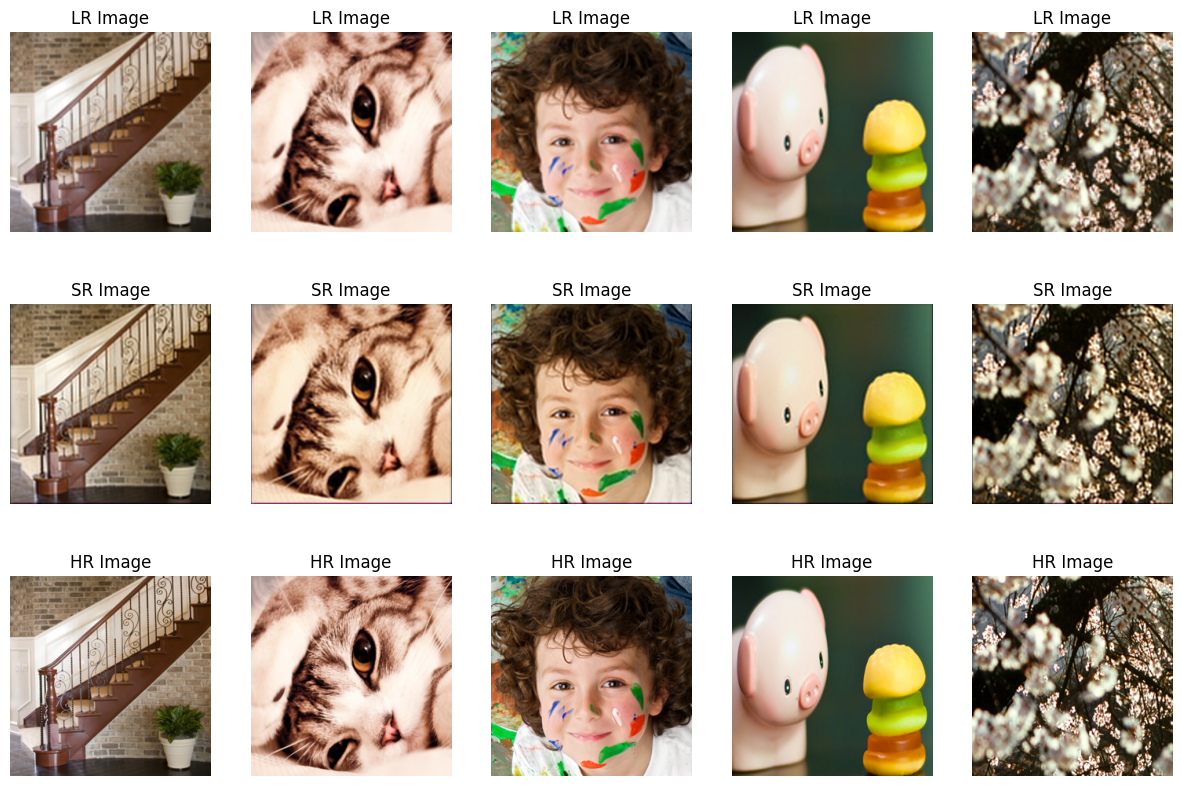

In [30]:
# Denormalize the pixel values
def denormalize(data):
    data = np.array(data)
    return (data * 255.).astype(np.uint8)

def predict(image, model):
    image = np.expand_dims(image, axis=0)
    sr = model.predict(image)
    sr = sr[0]
    sr = np.clip(sr * 255.0, 0, 255).astype(np.uint8)
    return sr

def predict_images(images, model):
    sr_images = []
    for img in images:
        sr_image = predict(img, model)
        sr_images.append(sr_image)
    return sr_images

# Plotting the images
sr_test_images = predict_images(X_test, srcnn_model)
y_test = denormalize(y_test)
X_test = denormalize(X_test)

fig, axs = plt.subplots(3, 5, figsize=(15, 10))

for i in range(5):
    axs[0, i].imshow(X_test[i])
    axs[0, i].set_title('LR Image')
    axs[0, i].axis('off')

    axs[1, i].imshow(sr_test_images[i])
    axs[1, i].set_title('SR Image')
    axs[1, i].axis('off')

    axs[2, i].imshow(y_test[i])
    axs[2, i].set_title('HR Image')
    axs[2, i].axis('off')

In [31]:
# Evaluate the model
def evaluate_model(input_images, testing_images):
    psnr_values = []
    ssim_values = []
    mse_values = []

    print("\nEvaluation Metrics:")
    for i in range(len(input_images)):
        m, s, p = compare_images(input_images[i], testing_images[i])
        psnr_values.append(p)
        ssim_values.append(s)
        mse_values.append(m)

        # print(f"\nComparison {i+1}:")
        # print(f'  PSNR: {p:.4f}')
        # print(f'  SSIM: {s:.4f}')
        # print(f'  MSE: {m:.4f}')

    print("\nOverall Evaluation Metrics:")
    print(f'Average PSNR: {np.mean(psnr_values):.4f}')
    print(f'Average SSIM: {np.mean(ssim_values):.4f}')
    print(f'Average MSE: {np.mean(mse_values):.4f}')
    print(f'Range of PSNR: {np.min(psnr_values):.4f} - {np.max(psnr_values):.4f}')
    print(f'Range of SSIM: {np.min(ssim_values):.4f} - {np.max(ssim_values):.4f}')
    print(f'Range of MSE: {np.min(mse_values):.4f} - {np.max(mse_values):.4f}')


In [32]:
evaluate_model(y_test, sr_test_images)
evaluate_model(X_test, y_test)


Evaluation Metrics:

Overall Evaluation Metrics:
Average PSNR: 23.6821
Average SSIM: 0.8624
Average MSE: 309.1445
Range of PSNR: 20.6837 - 28.2421
Range of SSIM: 0.7065 - 0.9514
Range of MSE: 97.4688 - 555.5400

Evaluation Metrics:

Overall Evaluation Metrics:
Average PSNR: 29.5170
Average SSIM: 0.8976
Average MSE: 121.1912
Range of PSNR: 22.6294 - 41.4564
Range of SSIM: 0.7836 - 0.9795
Range of MSE: 4.6499 - 354.9245


In [33]:
output_dir = 'output_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, img in enumerate(sr_test_images):
    img = Image.fromarray(img)
    img.save(os.path.join(output_dir, f'sr_image_{i}.png'))

print(f'All images saved to {output_dir}')

All images saved to output_images
